In [3]:
import os, sys

sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from nbafuns import *
from catboost import CatBoostRegressor, CatBoostClassifier

data_DIR = "../data/rapm/"
misc_DIR = "../data/misc/"
model_path = "../data/models/"
pbp_DIR = "../data/pbpdata/"
fig_DIR = "../figs/analysis/"

team_dict, team_list  = get_teams()

In [4]:
dfw = pd.read_parquet(data_DIR + "NBA_rapm_possessions_odds_2017_2024.parquet")
dfw["spreadm"] = dfw["spread"]*(dfw["secs"]/48/60)**4
features = ['margin','secs','spreadm','period']
len(dfw)

1626774

In [ ]:
dfw.columns

## Features

In [5]:
features = ['margin','secs','spreadm','period']
rr = 22

In [6]:
test_gid = dfw['gid'].sample(frac=0.8, random_state=rr).to_list()
dfw11 = dfw[dfw['gid'].isin(test_gid)]
dfw12 = dfw11.query("secs <=120")
for i in range(4):
    dfw11  = pd.concat([dfw11,dfw12])
dfw1 = dfw11
dfw2 = dfw[dfw['gid'].isin(test_gid)]

X_train =  dfw1[features].values
y_train = dfw1['win'].values
X_test =  dfw2[features].values
y_test = dfw2['win'].values
X = dfw[features].values
y = dfw['win'].values

In [7]:
X_train

array([[-2.00000000e+00,  2.88000000e+03, -4.50000000e+00,
         1.00000000e+00],
       [-2.00000000e+00,  2.84700000e+03, -4.29726792e+00,
         1.00000000e+00],
       [-2.00000000e+00,  2.84100000e+03, -4.26115663e+00,
         1.00000000e+00],
       ...,
       [ 7.00000000e+00,  1.47000000e+01, -3.73303513e-09,
         4.00000000e+00],
       [ 5.00000000e+00,  1.18000000e+01, -1.54996099e-09,
         4.00000000e+00],
       [ 5.00000000e+00,  9.10000000e+00, -5.48224333e-10,
         4.00000000e+00]])

## Catboost

In [8]:
# model = CatBoostRegressor(learning_rate=1, depth=6, loss_function='RMSE')
model = CatBoostClassifier(loss_function="Logloss",task_type="GPU",learning_rate=0.1,depth=12)
fit_model = model.fit(X_train, y_train, plot=True, eval_set=(X_test,y_test),verbose=50)
# print(fit_model.get_params())

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6779899	test: 0.6775768	best: 0.6775768 (0)	total: 327ms	remaining: 5m 27s
50:	learn: 0.6035362	test: 0.6022740	best: 0.6022740 (50)	total: 14.1s	remaining: 4m 23s
100:	learn: 0.5986120	test: 0.5979081	best: 0.5979081 (100)	total: 26.5s	remaining: 3m 56s
150:	learn: 0.5954960	test: 0.5953166	best: 0.5953166 (150)	total: 38.6s	remaining: 3m 36s
200:	learn: 0.5932558	test: 0.5937970	best: 0.5937970 (200)	total: 50.1s	remaining: 3m 19s
250:	learn: 0.5915854	test: 0.5926165	best: 0.5926165 (250)	total: 1m 1s	remaining: 3m 2s
300:	learn: 0.5902562	test: 0.5917364	best: 0.5917364 (300)	total: 1m 13s	remaining: 2m 49s
350:	learn: 0.5891894	test: 0.5910282	best: 0.5910282 (350)	total: 1m 24s	remaining: 2m 36s
400:	learn: 0.5881098	test: 0.5903357	best: 0.5903357 (400)	total: 1m 36s	remaining: 2m 23s
450:	learn: 0.5872267	test: 0.5897698	best: 0.5897698 (450)	total: 1m 47s	remaining: 2m 11s
500:	learn: 0.5863729	test: 0.5892360	best: 0.5892360 (500)	total: 1m 59s	remaining: 1m 59s
5

In [15]:
from sklearn.metrics import accuracy_score, log_loss

In [16]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > 0.5).astype(int)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
logloss = log_loss(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"Log Loss: {logloss:.4f}")

Accuracy: 0.6833
Log Loss: 0.5848


In [9]:
ypred = model.predict_proba(X_test)

In [10]:
i=0

In [11]:
dfw2["wp"] = ypred[:,1]
gameids = dfw2.gid.unique()
# gid = gameids[np.random.randint(0,len(gameids))]
gid = gameids[i]
i+=1

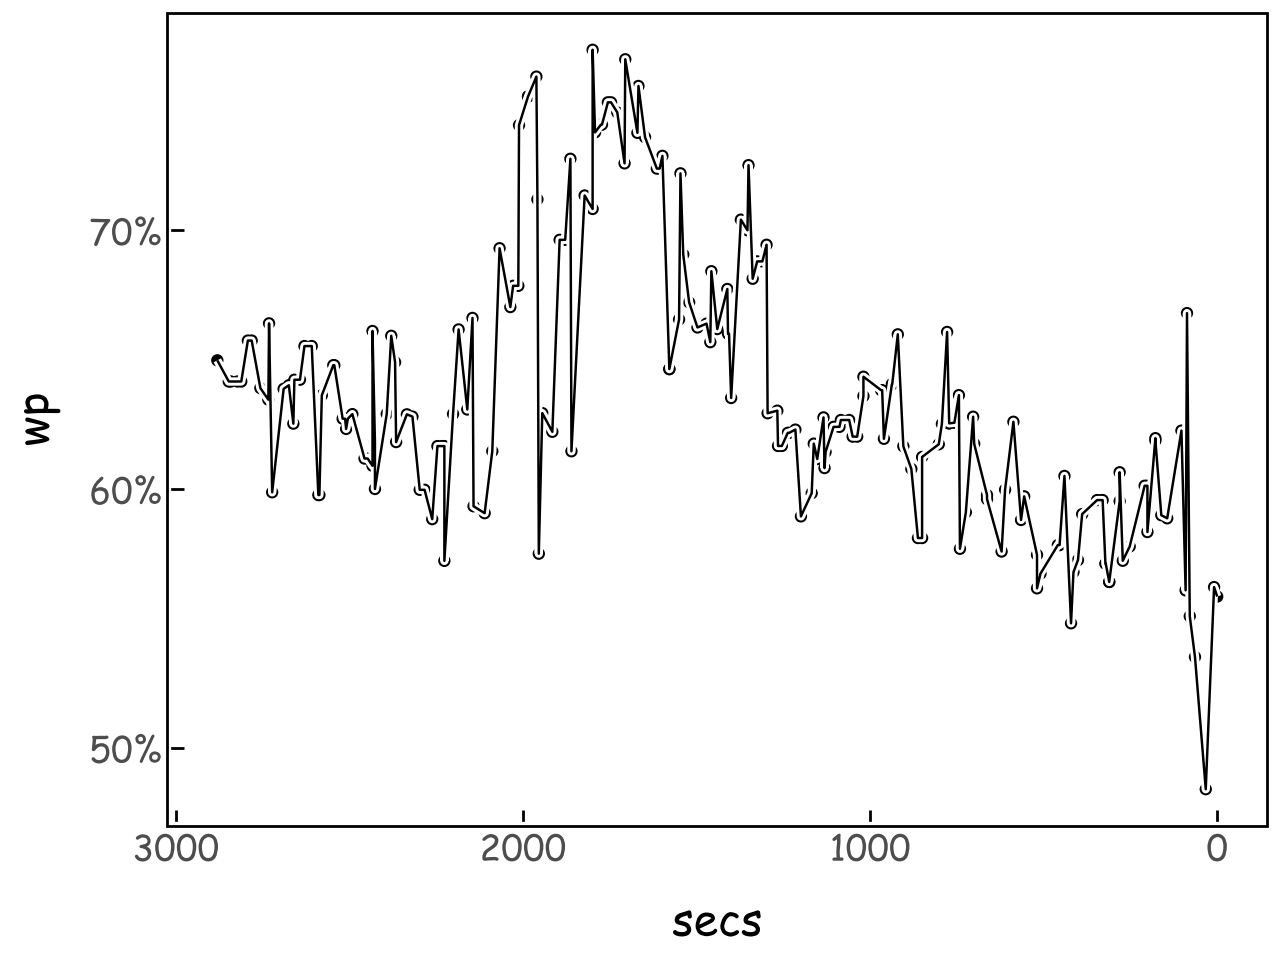

In [12]:
data = dfw2.query(f"gid == '{gid}'")
p = (
    ggplot(data)
    + aes(x="secs",y="wp")
    + geom_point()
    + geom_line()
    + scale_y_continuous(labels=percent_format())
    + scale_x_reverse()
    + theme_idv
)
p

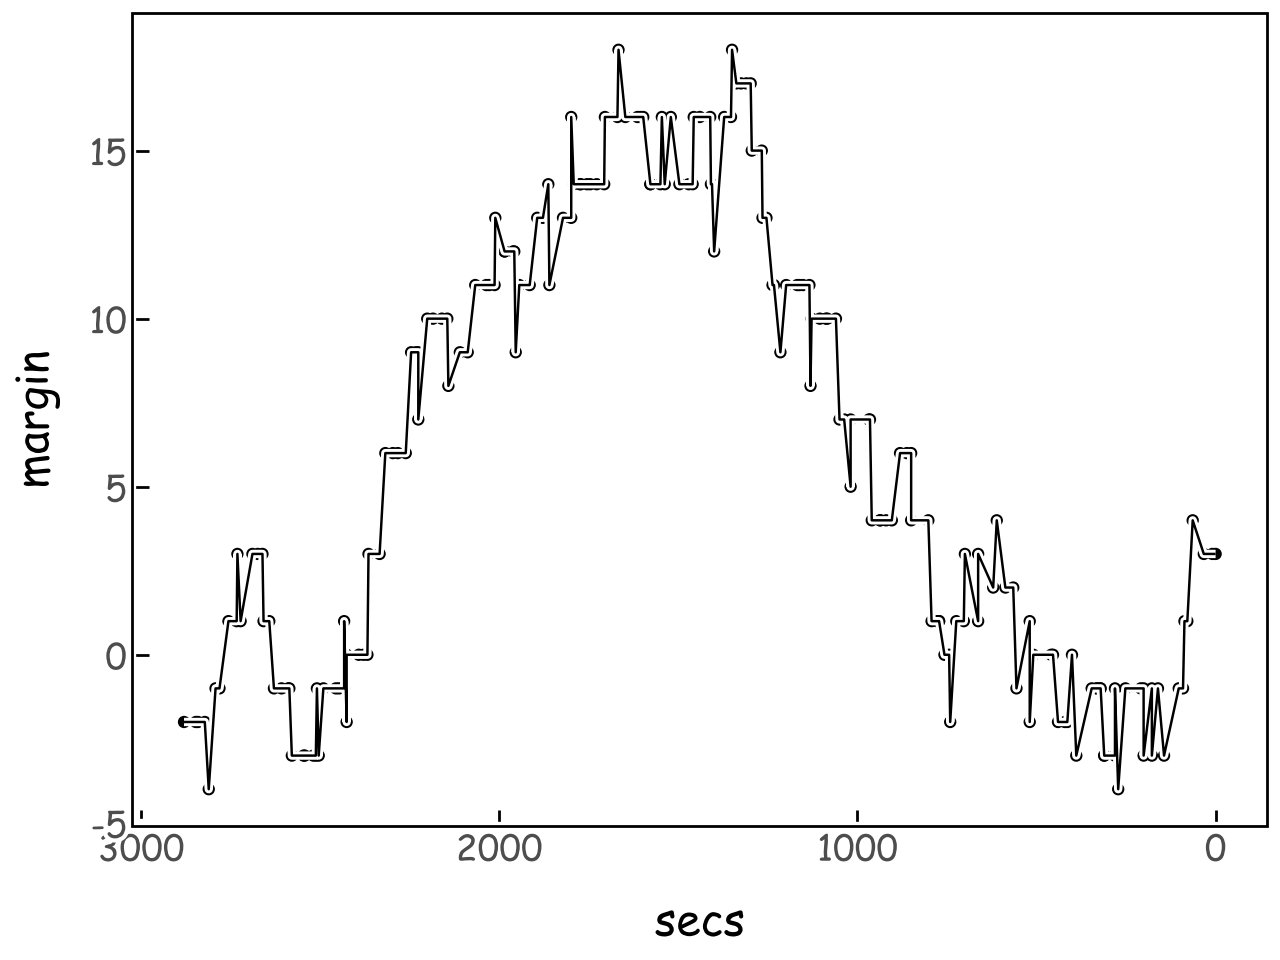

In [13]:
p1 = (
    ggplot(data)
    + aes(x="secs",y="margin")
    + geom_point()
    + geom_line()
    + scale_x_reverse()
    + theme_idv
)
p1

In [14]:
gfhfg

NameError: name 'gfhfg' is not defined

In [ ]:
line =  5
dfw3 = dfw2.query(f"spread == {line}")
p = (
    ggplot(dfw3)
    + aes(x="secs",y="wp",group="gid")
    + geom_smooth(se=False,size=0.3)
    + scale_x_reverse()
    + scale_y_continuous(labels=percent_format())
    + theme_idv
    + labs(
        # title = f"{team_dict[dfw1["tida"].iloc[0]]} vs {team_dict[dfw1["tidh"].iloc[0]]}"
    )
)
p